In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import ray
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2

from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL

In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1.gin',
                   '../sparse_causal_model_learner_rl/configs/kc_dec.gin',
                   '../keychest/config/5x5_1f1c1k_obs.gin'])

['kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1', 'kc_dec', '5x5_1f1c1k_obs']

In [3]:
gin.bind_parameter('Config.collect_remotely', True)
gin.bind_parameter('Config.n_collectors', 30)
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.future_buffer_size', 50)
gin.bind_parameter('Normalizer.type_', 'meanstd')
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', True)

In [4]:
ray.init(ignore_reinit_error=True)

2021-02-05 19:53:27,033	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.90.38.7',
 'raylet_ip_address': '10.90.38.7',
 'redis_address': '10.90.38.7:6379',
 'object_store_address': '/tmp/ray/session_2021-02-05_19-53-26_487977_40279/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-05_19-53-26_487977_40279/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-02-05_19-53-26_487977_40279',
 'metrics_export_port': 51110,
 'node_id': 'a91efbe31d69534e5feb7e2748640c4b0ac606e3'}

In [14]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512, 256])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [15]:
learner = CausalModelLearnerRL(Config(ray_kwargs={'address': '127.0.0.1:6379'}))

2021-02-05 19:55:16,272	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name af6422b4-67e3-11eb-8ff1-90e2baa1a248
Make environment KeyChest-v0 None {}


In [16]:
learner.create_trainables()

In [17]:
learner.decoder

ModelDecoder(
  (model): FCNet(
    (fc01): Linear(in_features=847, out_features=512, bias=True)
    (fc02): Linear(in_features=512, out_features=256, bias=True)
    (fc03): Linear(in_features=256, out_features=30, bias=True)
  )
)

In [18]:
env = learner.env

In [19]:
losses = []
dplus = []

In [20]:
opt = torch.optim.Adam(lr=1e-3, params=learner.decoder.parameters())

In [21]:
for i in tqdm(range(1000)):
    if i % 1 == 0:
        ctx = learner.collect_and_get_context()
    
    opt.zero_grad()
    l_obj = siamese_feature_discriminator_l2(**ctx)
    loss = l_obj['loss']
    loss.backward()
    opt.step()
    losses.append(loss.item())
    dplus.append(l_obj['metrics']['distance_plus'])

(pid=40506) Make environment KeyChest-v0 None {}
(pid=40500) Make environment KeyChest-v0 None {}
(pid=40502) Make environment KeyChest-v0 None {}
(pid=40503) Make environment KeyChest-v0 None {}
(pid=40513) Make environment KeyChest-v0 None {}
(pid=40526) Make environment KeyChest-v0 None {}
(pid=40507) Make environment KeyChest-v0 None {}
(pid=40505) Make environment KeyChest-v0 None {}
(pid=40495) Make environment KeyChest-v0 None {}
(pid=40497) Make environment KeyChest-v0 None {}
(pid=40493) Make environment KeyChest-v0 None {}
(pid=40501) Make environment KeyChest-v0 None {}
(pid=9260) Make environment KeyChest-v0 None {}
(pid=40504) Make environment KeyChest-v0 None {}
(pid=9261) Make environment KeyChest-v0 None {}
(pid=40494) Make environment KeyChest-v0 None {}
(pid=9280) Make environment KeyChest-v0 None {}
(pid=40499) Make environment KeyChest-v0 None {}
(pid=9262) Make environment KeyChest-v0 None {}
(pid=9290) Make environment KeyChest-v0 None {}
(pid=9268) Make environme

KeyboardInterrupt: 

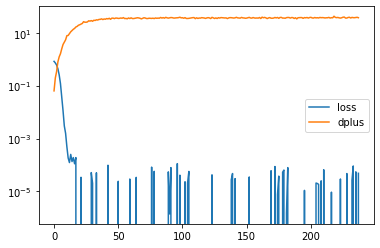

In [22]:
plt.plot(losses, label='loss')
plt.plot(dplus, label='dplus')
plt.yscale('log')
plt.legend()

In [36]:
np.mean(losses[-50:]), np.median(losses[-50:])

(4.3511369422049026e-05, 2.904087432398228e-05)

In [23]:
features = learner.decoder(ctx['obs'])

In [24]:
f = features.detach().cpu().numpy()

In [25]:
f.shape

(5007, 30)

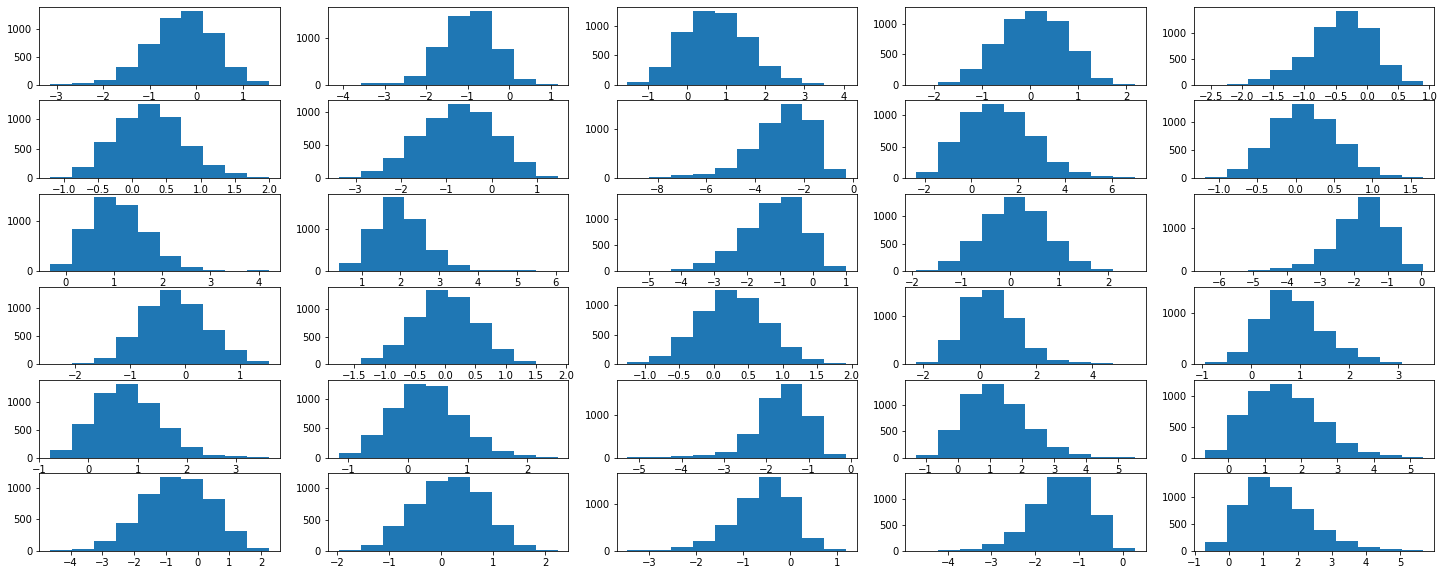

In [26]:
plt.figure(figsize=(25, 10))
for i_f in range(f.shape[1]):
    plt.subplot(6, 5, i_f + 1)
    plt.hist(f[:, i_f])

In [27]:
pd.DataFrame(f).std()

0     0.679794
1     0.640208
2     0.814897
3     0.665514
4     0.505844
5     0.495118
6     0.810932
7     1.276578
8     1.467124
9     0.421850
10    0.614594
11    0.748396
12    0.930461
13    0.647362
14    0.849103
15    0.586195
16    0.522231
17    0.493458
18    1.023733
19    0.650239
20    0.654487
21    0.559858
22    0.639314
23    0.962973
24    0.956548
25    1.058285
26    0.644025
27    0.613595
28    0.662019
29    0.982542
dtype: float32

<AxesSubplot:>

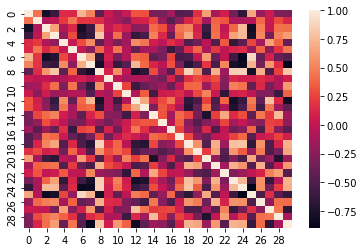

In [28]:
sns.heatmap(pd.DataFrame(f).corr())

In [29]:
env.engine.return_rgb = False

In [190]:
gin.bind_parameter('model_gnn/FCCombinedModel.activation_cls', torch.nn.LeakyReLU)
gin.bind_parameter('model_gnn/FCCombinedModel.hidden_sizes', [100, 100, 100])

In [191]:
learner.non_sparse_model.__init__(feature_shape=learner.feature_shape,
                                  action_shape=learner.action_shape,
                                  additional_feature_shape=learner.additional_feature_shape)
learner.non_sparse_model = learner.non_sparse_model.cuda()

In [192]:
learner.non_sparse_model.model.model.activation

[LeakyReLU(negative_slope=0.01),
 LeakyReLU(negative_slope=0.01),
 LeakyReLU(negative_slope=0.01),
 None]

In [193]:
learner.non_sparse_model

ManyNetworkCombinedModel(
  (bn): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [194]:
learner.non_sparse_model.model.enable_switch

False

In [195]:
mins = None
maxes = None

In [196]:
def normalize(t, mins, maxes):
    return 2 * ((t - mins) / (1e-3 + maxes - mins) - 0.5)

In [197]:
class AdhocWorldModel(nn.Module):
    def __init__(self):
        super(AdhocWorldModel, self).__init__()
        dim = 60
        self.bn = torch.nn.BatchNorm1d(num_features=34)
        self.fc1 = nn.Linear(in_features=34, out_features=dim)
        self.fc2 = nn.Linear(in_features=dim, out_features=dim)
        self.fc3 = nn.Linear(in_features=dim, out_features=dim)
        self.fc4 = nn.Linear(in_features=dim, out_features=32)
        self.activation = nn.Tanh()
        
    def forward(self, f_t, a_t, all):
        x = torch.cat([f_t, a_t], dim=1)
        
        x = self.bn(x)
        
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        return x

In [227]:
losses = []
metrics = []
losses_emb = []
losses_fit = []
ctx_set = False

In [228]:
#use_model = learner.non_sparse_model
use_model = AdhocWorldModel().cuda()

In [229]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [230]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [231]:
opt = torch.optim.SGD(lr=1e-2, params=list(use_model.parameters())+list(learner.decoder.parameters()))

In [232]:
def fit_loss(obs_x, obs_y, action_x, decoder, model, additional_feature_keys,
             model_forward_kwargs=None,
             fill_switch_grad=False,
             opt_label=None,
             divide_by_std=False,
             std_eps=0.05,
             **kwargs):
    """Ensure that the model fits the features data."""

    if model_forward_kwargs is None:
        model_forward_kwargs = {}
    
    f_t1 = decoder(obs_y)#.detach()
        
    have_additional = False
    if additional_feature_keys:
        have_additional = True
        add_features_y = torch.cat([kwargs[k] for k in additional_feature_keys], dim=1)
        
        # WARNING: zeroing output features
#         f_t1 = torch.zeros_like(f_t1)
        f_t1 = torch.cat([f_t1, add_features_y], dim=1)
        
    # detaching second part like in q-learning makes the loss jitter

    f_t1_pred = model(decoder(obs_x), action_x, all=have_additional, **model_forward_kwargs)

    loss = (f_t1_pred - f_t1).pow(2)
    loss = loss.sum(1).mean()

    metrics = {'mean_feature': f_t1.mean(0).detach().cpu().numpy(),
               'std_feature': f_t1.std(0).detach().cpu().numpy(),
               'min_feature': f_t1.min().item(),
               'max_feature': f_t1.max().item(),
               #'std_feature_avg': f_t1_std.detach().cpu().numpy() if f_t1_std is not None else 0.0,
               #'inv_std_feature_avg': 1/f_t1_std.detach().cpu().numpy() if f_t1_std is not None else 0.0
              }

    return {'loss': loss,
            'metrics': metrics}

In [233]:
[x.mean() for x in learner.decoder.state_dict().values()]

[tensor(-2.7486e-05, device='cuda:0'),
 tensor(-0.0007, device='cuda:0'),
 tensor(8.0947e-05, device='cuda:0'),
 tensor(-0.0002, device='cuda:0')]

In [ ]:
for i in tqdm(range(50000)):
    if i % 1 == 0 or not ctx_set:
        ctx_set = True
        ctx = learner.collect_and_get_context()
        
#         if mins is None or maxes is None:
#             print("Computing minmax")
#             f_all = learner.decoder(ctx['obs'])
#             mins = f_all.min(dim=0, keepdim=True).values.detach()
#             maxes = f_all.max(dim=0, keepdim=True).values.detach()
        
#         f_t1 = learner.decoder(ctx['obs_y'])#.detach()
#         f_t = learner.decoder(ctx['obs_x'])#.detach()
        
# #         f_t1 = normalize(f_t1, mins, maxes)
# #         f_t = normalize(f_t, mins, maxes)
        
#         add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
#         f_t1 = torch.cat([f_t1, add_features_y], dim=1)
        
#     f_t1_pred = use_model(
#         f_t,
#         ctx['action_x'],
#         all=True)
    
    ctx['non_sparse_model_add'] = use_model
#     ctx['additional_feature_keys'] = []
    l_obj_emb = siamese_feature_discriminator_l2(**ctx)
    l_obj_fit = context_rewriter(function=fit_loss, rewrite={'model': 'non_sparse_model_add'},
                                 divide_by_std=False,
                                 **ctx)
    loss = l_obj_fit['loss'] #+ l_obj_emb['loss']

    
#     loss = nn.MSELoss()(f_t1, f_t1_pred)

    
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    losses_emb.append(l_obj_emb['loss'].item())
    losses_fit.append(l_obj_fit['loss'].item())
    m = {}
    m.update(l_obj_fit['metrics'])
    m.update(l_obj_emb['metrics'])
    metrics.append(m)

In [ ]:
plt.plot(losses, label='loss')
# plt.plot(losses_emb, label='emb')
plt.plot(losses_fit, label='fit')
#plt.plot(dplus, label='dplus')
plt.yscale('log')
plt.legend()

In [185]:
%%javascript
var jq = document.createElement('script');
jq.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.1.4/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(jq);

<IPython.core.display.Javascript object>

In [186]:
%load_ext jupyternotify
%autonotify -a 30

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [187]:
f_t1 = learner.decoder(ctx['obs_y'])#.detach()
f_t = learner.decoder(ctx['obs_x'])#.detach()

#         f_t1 = normalize(f_t1, mins, maxes)
#         f_t = normalize(f_t, mins, maxes)

add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
# f_t1 = torch.zeros_like(f_t1)
f_t1 = torch.cat([f_t1, add_features_y], dim=1)

f_t1_pred = use_model(
f_t,
ctx['action_x'],
all=True)


<AxesSubplot:>

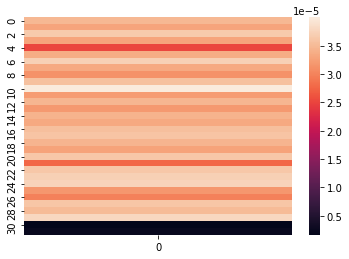

In [188]:
sns.heatmap((f_t1_pred - f_t1).pow(2).mean(0).cpu().detach().numpy().reshape(-1, 1))

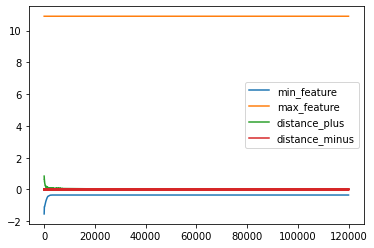

In [189]:
metrics_dct = lstdct2dctlst(metrics)
for key, vals in metrics_dct.items():
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key)
plt.legend()
plt.show()

In [163]:
metrics_dct.keys()

dict_keys(['mean_feature', 'std_feature', 'min_feature', 'max_feature', 'distance_plus', 'distance_minus'])

In [164]:
losses[-1]

0.00024205508816521615

In [83]:
learner.decoder(ctx['obs_x']).min()

tensor(-0.3339, device='cuda:0', grad_fn=<MinBackward1>)

In [ ]:
# metrics_dct['']